# SST analysis for CMIP5/6 ensemble...compute skill skore

In [1]:
#Functions and otherwise...

from netCDF4 import Dataset
import pylab as P
import Ngl
import ESMF
import Nio
import numpy as np
from numpy import ma
from numpy import dtype
import matplotlib
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import xarray as xr
import pandas as pd
import os
from scipy.interpolate import griddata
import wrf
from wrf import (getvar, to_np, vertcross, smooth2d, CoordPair, GeoBounds,
                 get_cartopy, latlon_coords, cartopy_xlim, cartopy_ylim)
import xesmf as xe
import dask
import gc
import datetime
import time
from scipy import stats
import regionmask
import cftime

ESMF.Manager(debug=True)

T0 = 273.16

states = cfeature.NaturalEarthFeature(category='cultural', scale='50m',
                                      facecolor='none',
                                      name='admin_1_states_provinces_shp')

#Read metadata (wrfinput file)
def _metaread(dir_meta,domain):
 file = "%swrfinput_%s" %(dir_meta,domain)
 data = xr.open_dataset(file)
 lat = data.variables["XLAT"]
 lon = data.variables["XLONG"]
 z = data.variables["HGT"]

 return (lat,lon,z,file)

#WRF reader function
def _wrfread(prefix,dir,var,domain):

 all_files = sorted(os.listdir(dir))

 anal_files = []
 for ii in all_files:
  if ii.startswith(var+"."):
   if domain in ii:
    if prefix in ii:
     anal_files.append(dir+str(ii))

 del all_files

 nf  = len(anal_files)

 data = xr.open_mfdataset(anal_files, combine="by_coords")
 var_read = data.variables[var]
 day = data.variables["day"].values
 nt = len(day)

 day1 = pd.to_datetime(str(int(day[0])), format='%Y-%m-%d')
 day2 = pd.to_datetime(str(int(day[nt-1])), format='%Y-%m-%d')
 dates = pd.date_range(day1,day2,freq="D")

 #Mask array setting leap years = True
 is_leap_day = (dates.month == 2) & (dates.day == 29)
 dates = dates[~is_leap_day]

 var_read = xr.DataArray(var_read, dims=['day','lat2d','lon2d'])
 var_read['day'] = dates    #year doesn't matter here

 return (var_read)

#WRF tier 3 reader function
def _wrfread_gcm(model,gcm,variant,dir,var,domain):

 all_files = sorted(os.listdir(dir))

 anal_files = []
 for ii in all_files:
  if ii.startswith(var+".") and model in ii and gcm in ii \
        and variant in ii and domain in ii:
   if domain in ii:
     anal_files.append(dir+str(ii))

 del all_files

 nf  = len(anal_files)

 data = xr.open_mfdataset(anal_files, combine="by_coords")
 var_read = data.variables[var]
 day = data.variables["day"].values
 nt = len(day)

 day1 = pd.to_datetime(str(int(day[0])), format='%Y-%m-%d')
 day2 = pd.to_datetime(str(int(day[nt-1])), format='%Y-%m-%d')
 dates = pd.date_range(day1,day2,freq="D")

 if gcm == 'cesm2':
  is_leap_day = (dates.month == 2) & (dates.day == 29)
  dates = dates[~is_leap_day]    

 var_read = xr.DataArray(var_read, dims=['day','lat2d','lon2d'])
 var_read['day'] = dates    #year doesn't matter here

 return (var_read)

def screen_times(data,date_start,date_end):
    #Dimensions should be "time"
    dask.config.set(**{'array.slicing.split_large_chunks': True})
    data = data.sel(time=~((data.time.dt.month < date_start[1]) & (data.time.dt.year <= date_start[0])))
    data = data.sel(time=~((data.time.dt.year < date_start[0])))
    data = data.sel(time=~((data.time.dt.month >= date_end[1]) & (data.time.dt.year >= date_end[0])))
    data = data.sel(time=~((data.time.dt.year > date_end[0])))

    return(data)

def screen_times_wrf(data,date_start,date_end):
    #Dimensions should be "day"
    dask.config.set(**{'array.slicing.split_large_chunks': True})
    data = data.sel(day=~((data.day.dt.month < date_start[1]) & (data.day.dt.year <= date_start[0])))
    data = data.sel(day=~((data.day.dt.year < date_start[0])))
    data = data.sel(day=~((data.day.dt.month >= date_end[1]) & (data.day.dt.year >= date_end[0])))
    data = data.sel(day=~((data.day.dt.year > date_end[0])))
    
    return(data)

def screen_times_wrf_year_only(data,date_start,date_end):
    #Dimensions should be "day"
    dask.config.set(**{'array.slicing.split_large_chunks': True})
    data = data.sel(day=~((data.day.dt.year < date_start[0])))
    data = data.sel(day=~((data.day.dt.year > date_end[0])))
    
    return(data)

def _dir_sel(prefix):
    if prefix == '.mpi-esm1-2-lr_hist_r8i1p1f1':
        label = 'mpi_r8'
    if prefix == '.mpi-esm1-2-lr_hist_r7i1p1f1':
        label = 'mpi_r7'
    if prefix == '.cesm2_hist_r11i1p1f1':
        label = 'cesm2_r11_ssp370'
    if prefix == '.era5':
        label = 'era'
    if prefix == '.era5_test1':
        label = 'pert'
    if prefix == '.era5_test2':
        label = 'pert'
    if prefix == '.era5_test3':
        label = 'pert'
    if prefix == '.era5_test4':
        label = 'pert'
    if prefix == '.era5_test5':
        label = 'pert'
    if prefix == '.era5_test6':
        label = 'pert'
    if prefix == '.era5_test7':
        label = 'pert'
    if prefix == '.era5_test8':
        label = 'pert'
    if prefix == '.cesm2_ssp370_BIAS_CORRECT':
        label = 'cesm2_r11_ssp370_bc'
    
    return (label)

#For latitude/longitude
def _sst_average1(dir,header,ds_out,date_start,date_end,sst_era5_final):
    
    data = xr.open_mfdataset(dir+header,combine='by_coords')
    data = screen_times(data,date_start,date_end)

    ds = xr.DataArray(data.tos, dims=['time','y','x'], \
        coords={'lon': (['y', 'x'], data.longitude), \
        'lat': (['y', 'x'], data.latitude), \
        'time': (['time'], data.time) } )

    regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=True,ignore_degenerate=True,reuse_weights=False)
    tos = data.tos
    tos = xr.where(tos > 0.,tos,np.nan)
    sst = regridder(tos)

    weights = np.cos(np.deg2rad(ds_out.lat))
    weights.name = "weights"

    return(sst,weights)

#For lat/lon
def _sst_average2(dir,header,ds_out,date_start,date_end,sst_era5_final):
    
    data = xr.open_mfdataset(dir+header,combine='by_coords')
    data = screen_times(data,date_start,date_end)

    ds = xr.DataArray(data.tos, dims=['time','y','x'], \
        coords={'lon': (['y', 'x'], data.lon), \
        'lat': (['y', 'x'], data.lat), \
        'time': (['time'], data.time) } )
    
    regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=True,ignore_degenerate=True,reuse_weights=False)
    tos = data.tos
    tos = xr.where(tos > 0.,tos,np.nan)  #some datasets have zeros where they should be np.nans
    sst = regridder(tos)
    
    return(sst)

#For lat/lon on a rectilinear grid
def _sst_average3(dir,header,ds_out,date_start,date_end,sst_era5_final):
    
    data = xr.open_mfdataset(dir+header,combine='by_coords')
    data = screen_times(data,date_start,date_end)

    ds = xr.DataArray(data.tos, dims=['time','lat','lon'], \
        coords={'lon': (['lon'], data.lon), \
        'lat': (['lat'], data.lat), \
        'time': (['time'], data.time) } )

    regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=True,ignore_degenerate=True,reuse_weights=False)
    tos = data.tos
    tos = xr.where(tos > 0.,tos,np.nan)
    sst = regridder(tos)

    return(sst)

#For nav_lat/nav_lon
def _sst_average4(dir,header,ds_out,date_start,date_end,sst_era5_final):
    
    data = xr.open_mfdataset(dir+header,combine='by_coords')
    data = screen_times(data,date_start,date_end)

    ds = xr.DataArray(data.tos, dims=['time','y','x'], \
        coords={'lon': (['y', 'x'], data.nav_lon), \
        'lat': (['y', 'x'], data.nav_lat), \
        'time': (['time'], data.time) } )
    
    regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=True,ignore_degenerate=True,reuse_weights=False)
    tos = data.tos
    tos = xr.where(tos > 0.,tos,np.nan)
    sst = regridder(tos)
    return(sst)

#For latitutde/longitude on a rectilinear grid
def _sst_average5(dir,header,ds_out,date_start,date_end,sst_era5_final):
    
    data = xr.open_mfdataset(dir+header,combine='by_coords')
    data = screen_times(data,date_start,date_end)

    ds = xr.DataArray(data.tos, dims=['time','lat','lon'], \
        coords={'lon': (['lon'], data.longitude), \
        'lat': (['lat'], data.latitude), \
        'time': (['time'], data.time) } )

    regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=True,ignore_degenerate=True,reuse_weights=False)
    tos = data.tos
    tos = xr.where(tos > 0.,tos,np.nan)
    sst = regridder(tos)
    
    return(sst)

print ("Functions loaded")

Functions loaded


# Read in ERA5 data and interpolate to defined grid

Overwrite existing file: bilinear_281x361_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.
<xarray.DataArray 'SSTK' (time: 419, lat: 64, lon: 70)>
dask.array<transpose, shape=(419, 64, 70), dtype=float64, chunksize=(12, 64, 70), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2014-11-01
  * lon      (lon) int64 -160 -159 -158 -157 -156 -155 ... -95 -94 -93 -92 -91
  * lat      (lat) int64 6 7 8 9 10 11 12 13 14 ... 61 62 63 64 65 66 67 68 69
Attributes:
    regrid_method:  bilinear
CPU times: user 2.46 s, sys: 107 ms, total: 2.57 s
Wall time: 2.57 s


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


3970

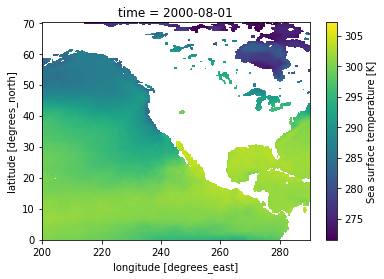

In [4]:
%%time

date_start, date_end = [1980,1,1], [2014,12,31]

ds_out = xr.Dataset({'lat': (['lat'], np.arange(6, 70, 1)),
                     'lon': (['lon'], np.arange(-160, -90, 1)),
                    }
                   )
    
dir = "/mnt/parm/raid/data/WRF_2020/bc_files/"

#ERA5
era5_data = []
data = xr.open_mfdataset("/data/public/reanalysis/era5/era5_monthly/*sst*nc",combine="by_coords")
data = data.sel(latitude=slice(70,0),longitude=slice(200,290) )
data = screen_times(data,date_start,date_end)

data.SSTK.sel(time="2000-08-01").plot()
ds = data.rename({'longitude': 'lon', 'latitude': 'lat'})
era5_regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=True,ignore_degenerate=True,reuse_weights=False)

sst_era5 = era5_regridder(data.SSTK)#.mean(dim='time')

print (sst_era5)

sst_era5_final = sst_era5

gc.collect()

# CMIP6 GCM interpolation and subsetting using bilinear

In [5]:
date_start, date_end = [1980,1,1], [2014,12,31]
dir = "/data/public/gcm/CMIP6/native/mon/historical/tos/"

sst_cmip6 = {}

sst_cmip6['* ACCESS-CM2'], weights = _sst_average1(dir,
                    "*ACCESS-CM2_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['ACCESS-ESM1-6'], weights = _sst_average1(dir,
                    "*ACCESS-ESM1-5_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['* BCC-CSM2-MR'], weights = _sst_average1(dir,
                    "*BCC-CSM2-MR_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['BCC-ESM1'], weights = _sst_average1(dir,
                    "*BCC-ESM1_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['CAMS-CSM1-0'], weights = _sst_average1(dir,
                    "*CAMS-CSM1-0_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['CanESM5-CanOE'], weights = _sst_average1(dir,
                    "*CanESM5-CanOE_historical_r1i1p2f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['* CanESM5'], weights = _sst_average1(dir,
                    "*CanESM5_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['CAS-ESM2-0'] = _sst_average3(dir,
                    "*CAS-ESM2-0_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['CESM2-FV2']  = _sst_average2(dir,
                    "*CESM2-FV2_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['* CESM2']  = _sst_average2(dir,
                    "*CESM2_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['CESM2-WACCM-FV2']  = _sst_average2(dir,
                    "*CESM2-WACCM-FV2_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['CIESM'], weights  = _sst_average1(dir,
                    "*CIESM_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['CMCC-CM2-SR5'], weights  = _sst_average1(dir,
                    "*CMCC-CM2-SR5_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['CNRM-CM6-1']  = _sst_average2(dir,
                    "*CNRM-CM6-1_historical_r1i1p1f2_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['CNRM-CM6-1-HR']  = _sst_average2(dir,
                    "*CNRM-CM6-1-HR_historical_r1i1p1f2_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['* CNRM-ESM2-1']  = _sst_average2(dir,
                    "*CNRM-ESM2-1_historical_r1i1p1f2_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

'''sst_cmip6['E3SM-1-0']    = _sst_average3(dir,
                    "*E3SM-1-0_historical_r1i1p1f1_gr*",
                    ds_out,date_start,date_end,sst_era5_final)'''

sst_cmip6['E3SM-1-1-ECA']  = _sst_average3(dir,
                    "*E3SM-1-1-ECA_historical_r1i1p1f1_gr*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['E3SM-1-1']  = _sst_average3(dir,
                    "*E3SM-1-1_historical_r1i1p1f1_gr*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['EC-Earth3'], weights  = _sst_average1(dir,
                    "*EC-Earth3_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['EC-Earth3-Veg'], weights  = _sst_average1(dir,
                    "*EC-Earth3-Veg_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['EC-Earth3-Veg-LR'], weights  = _sst_average1(dir,
                    "*EC-Earth3-Veg-LR_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['FGOALS-f3-L'], weights  = _sst_average1(dir,
                    "*FGOALS-f3-L_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['* FGOALS-g3'], weights  = _sst_average1(dir,
                    "*FGOALS-g3_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['FIO-ESM-2-0'], weights  = _sst_average1(dir,
                    "*FIO-ESM-2-0_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['GFDL-CM4']  = _sst_average2(dir,
                    "*GFDL-CM4_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['GFDL-ESM4']  = _sst_average2(dir,
                    "*GFDL-ESM4_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['GISS_E2-1-G']  = _sst_average3(dir,
                    "*GISS-E2-1-G_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['* HadGEM3-GC31-LL'], weights  = _sst_average1(dir,
                    "*HadGEM3-GC31-LL_historical_r1i1p1f3_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['* HadGEM3-GC31-MM'], weights  = _sst_average1(dir,
                    "*HadGEM3-GC31-MM_historical_r1i1p1f3_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['INM-CM4-8']  = _sst_average3(dir,
                    "*INM-CM4-8_historical_r1i1p1f1_gr1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['INM-CM5-0']  = _sst_average3(dir,
                    "*INM-CM5-0_historical_r1i1p1f1_gr1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['IPSL-CM6A-LR']  = _sst_average4(dir,
                    "*IPSL-CM6A-LR_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['KACE-1-0-G'], weights   = _sst_average1(dir,
                    "*KACE-1-0-G_historical_r1i1p1f1_gr*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['MCM-UA-1-0']   = _sst_average5(dir,
                    "*MCM-UA-1-0_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['* MIROC6'], weights  = _sst_average1(dir,
                    "*MIROC6_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['MIROC6-ES2l'], weights  = _sst_average1(dir,
                    "*MIROC-ES2L_historical_r1i1p1f2_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['* MPI-ESM-1-2-HAM'], weights  = _sst_average1(dir,
                    "*MPI-ESM-1-2-HAM_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['* MPI-ESM1-2-HR'], weights   = _sst_average1(dir,
                    "*MPI-ESM1-2-HR_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['* MPI-ESM1-2-LR'], weights  = _sst_average1(dir,
                    "*MPI-ESM1-2-LR_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['NESM3'], weights  = _sst_average1(dir,
                    "*NESM3_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['* MRI-ESM2-0'], weights  = _sst_average1(dir,
                    "*MRI-ESM2-0_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['NorCPM1'], weights  = _sst_average1(dir,
                    "*NorCPM1_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['* NorESM2-LM'], weights  = _sst_average1(dir,
                    "*NorESM2-LM_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['* NorESM2-MM'], weights  = _sst_average1(dir,
                    "*NorESM2-MM_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['SAM0-UNICON'], weights  = _sst_average1(dir,
                    "*SAM0-UNICON_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['TaiESM1'], weights  = _sst_average1(dir,
                    "*TaiESM1_historical_r1i1p1f1_gn*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip6['UKESM1-0-LL'], weights  = _sst_average1(dir,
                    "*UKESM1-0-LL_historical_r1i1p1f2*",
                    ds_out,date_start,date_end,sst_era5_final)
gc.collect()

Overwrite existing file: bilinear_300x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_300x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_232x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_232x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_200x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_291x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_291x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_196x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/work/srahimi/clone/lib/python3.7/site-packages/xesmf/backend.py:52: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn("Latitude is outside of [-90, 90]")


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_292x362_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_294x362_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_1050x1442_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_294x362_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_180x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_180x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_292x362_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_292x362_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_292x362_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_218x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_218x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_1080x1440_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_576x720_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_90x144_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_330x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_1205x1440_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_180x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_180x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_332x362_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_200x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_80x192_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_256x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_256x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_220x256_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_404x802_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_220x256_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_292x362_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_363x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_385x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_385x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_330x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


10788

# CMIP5 GCMs

In [6]:
%%time

date_start, date_end = [1970,1,1], [2005,12,31]
dir = "/data/public/gcm/CMIP5/native/month/historical/tos/"

sst_cmip5 = {}

sst_cmip5['ACCESS1-0'] = _sst_average2(dir,
                    "*ACCESS1-0_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['ACCESS1-3'] = _sst_average2(dir,
                    "*ACCESS1-3_historical_r2i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['bcc-csm1-1'] = _sst_average2(dir,
                    "*bcc-csm1-1_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['bcc-csm1-1-m'] = _sst_average2(dir,
                    "*bcc-csm1-1-m_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['CanCM4'] = _sst_average3(dir,
                    "*CanCM4_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['CanESM2'] = _sst_average3(dir,
                    "*CanESM2_historical_r1i1p1_*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['CCSM4'] = _sst_average2(dir,
                    "*CCSM4_historical_r1i1p1_*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['CESM1-BGC'] = _sst_average2(dir,
                    "*CESM1-BGC_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['CESM1-CAM5'] = _sst_average2(dir,
                    "*CESM1-CAM5_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['CESM1-FASTCHEM'] = _sst_average2(dir,
                    "*CESM1-FASTCHEM_historical_r1i1p1_*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['CESM1-WACCM'] = _sst_average2(dir,
                    "*CESM1-WACCM_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['CMCC-CESM'] = _sst_average2(dir,
                    "*CMCC-CESM_historical_r1i1p1_*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['CMCC-CM'] = _sst_average2(dir,
                    "*CMCC-CM_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['CMCC-CMS'] = _sst_average2(dir,
                    "*CMCC-CMS_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['CNRM-CM5-2'] = _sst_average2(dir,
                    "*CNRM-CM5-2_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['CNRM-CM5'] = _sst_average2(dir,
                    "*CNRM-CM5_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['CSIRO-Mk3-6-0'] = _sst_average3(dir,
                    "*CSIRO-Mk3-6-0_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['EC-EARTH'] = _sst_average2(dir,
                    "*EC-EARTH_historical_r11i1p1_*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['FIO-ESM'] = _sst_average2(dir,
                    "*FIO-ESM_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['GFDL-CM3'] = _sst_average2(dir,
                    "*GFDL-CM3_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['GFDL-ESM2G'] = _sst_average2(dir,
                    "*GFDL-ESM2G_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)


sst_cmip5['GISS-E2-H-CC'] = _sst_average3(dir,
                    "*GISS-E2-H-CC_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['GISS-E2-H'] = _sst_average3(dir,
                    "*GISS-E2-H_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['GISS-E2-R-CC'] = _sst_average3(dir,
                    "*GISS-E2-R-CC_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['GISS-E2-R'] = _sst_average3(dir,
                    "*GISS-E2-R_historical_r1i1p1_*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['HadCM3'] = _sst_average3(dir,
                    "*HadCM3_historical_r1i1p1_*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['HadCM2-AO'] = _sst_average3(dir,
                    "*HadGEM2-AO_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['HadCM2-CC'] = _sst_average3(dir,
                    "*HadGEM2-CC_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['HadCM2-E5'] = _sst_average3(dir,
                    "*HadGEM2-ES_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['inmcm4'] = _sst_average2(dir,
                    "*inmcm4_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['IPSL-CM5A-LR'] = _sst_average2(dir,
                    "*IPSL-CM5A-LR_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['IPSL-CM5B-LR'] = _sst_average2(dir,
                    "*IPSL-CM5B-LR_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['MIROC5'] = _sst_average2(dir,
                    "*MIROC5_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['MIROC-ESM-CHEM'] = _sst_average3(dir,
                    "*MIROC-ESM-CHEM_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['MIROC-ESM'] = _sst_average3(dir,
                    "*MIROC-ESM_historical_r1i1p1_*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['MPI-ESM-LR'] = _sst_average2(dir,
                    "*MPI-ESM-LR_historical_r1i1p1_*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['MPI-ESM-MR'] = _sst_average2(dir,
                    "*MPI-ESM-MR_historical_r1i1p1_*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['MRI-CGCM3'] = _sst_average2(dir,
                    "*MRI-CGCM3_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['MRI-ESM1'] = _sst_average2(dir,
                    "*_MRI-ESM1_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['NorESM1-ME'] = _sst_average2(dir,
                    "*NorESM1-ME_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)

sst_cmip5['NorESM1-M'] = _sst_average2(dir,
                    "*NorESM1-M_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)
    
data = xr.open_mfdataset(dir+"*FGOALS-g2_historical_r1i1p1*",combine='by_coords',decode_times=False)

times = cftime.num2date(data.time.values, \
                        "days since 0001-01-01", \
                        calendar='noleap',only_use_python_datetimes=True)

    
data['time'] = pd.to_datetime(times, format='%Y-%m-%d %H:%M%S:%f')

ds = xr.DataArray(data.tos, dims=['time','lat','lon'], \
        coords={'lon': (['lon'], data.lon), \
        'lat': (['lat'], data.lat), \
        'time': (['time'], data.time) } )

regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=True,ignore_degenerate=True,reuse_weights=False)
sst = regridder(data.tos) #+ 273.16

sst_cmip5['FGOALS-g2'] = sst#.mean(dim='time') - sst_era5_final

gc.collect()

Overwrite existing file: bilinear_300x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_300x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_232x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_232x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_192x256_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_192x256_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_149x182_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_149x182_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_149x182_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_292x362_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_292x362_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_189x192_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_292x362_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_200x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_210x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_90x144_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_90x144_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_90x144_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_90x144_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_144x288_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_216x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/xesmf/backend.py:52: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn("Latitude is outside of [-90, 90]")


Overwrite existing file: bilinear_216x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/xesmf/backend.py:52: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn("Latitude is outside of [-90, 90]")


Overwrite existing file: bilinear_216x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_340x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_149x182_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_149x182_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_224x256_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_192x256_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_192x256_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_220x256_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_404x802_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_368x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_368x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_196x360_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.
CPU times: user 1min 31s, sys: 36.9 s, total: 2min 8s
Wall time: 10min 16s


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


1377

# NMSE

In [7]:
%%time

#Weighted mean
def weighted_mean(da):
    
    # make 2d array of weights in case that lat is 1d
    if len(da.lat.shape)==2:
        weights=np.cos(np.deg2rad(da.lat))
    elif len(da.lat.shape)==1:
        weights = xr.ones_like(da)* (np.cos(np.deg2rad((da.lat))).values)[:,np.newaxis]
        
    weights = weights*da/da

    wm = (da*weights).sum() / weights.sum()
    return wm

def compute_nmse(gcm,ref):
    #gcm and ref should be 2d (lat,lon) and already have time dimension averaged out
    
    ref_variance = weighted_mean((ref - weighted_mean(ref))**2)
    #print (ref.values, weighted_mean(ref).values )

    nmse = (weighted_mean((gcm - ref)**2))/ref_variance
    return (nmse.values)

era5_mean = sst_era5.mean(dim='time').rename('tos')

#Fix CMIP6 SSTs to K
fix_sst_cmip6 = {}

for key in sst_cmip6.keys():
    modified =  sst_cmip6[key] + 273.16
    fix_sst_cmip6[key] = modified
    
#CMIP6
nmse_cmip6 = {}
for key in fix_sst_cmip6.keys():
    aaa = fix_sst_cmip6[key].mean(dim='time')
    nmse_cmip6[key] = compute_nmse(aaa,era5_mean)
    print (nmse_cmip6[key],key)

#CMIP5
nmse_cmip5 = {}
for key in sst_cmip5.keys():
    aaa = sst_cmip5[key].mean(dim='time')
    nmse_cmip5[key] = compute_nmse(aaa,era5_mean)
    print (nmse_cmip5[key],key)


print (nmse_cmip5)
print ("---------------")
print ("---------------")
print (nmse_cmip6)

gc.collect()

/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.028273750477015747 * ACCESS-CM2


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.02243030258986298 ACCESS-ESM1-6


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.037672405824223036 * BCC-CSM2-MR


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.04884065452407855 BCC-ESM1


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.039317006149447734 CAMS-CSM1-0


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.03444145816667492 CanESM5-CanOE


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.0344131348650588 * CanESM5


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.0253461610384852 CAS-ESM2-0


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.037223120926501686 CESM2-FV2


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.028566669392906648 * CESM2


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.045578116191252196 CESM2-WACCM-FV2


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.0564153695844071 CIESM


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.028828269344814406 CMCC-CM2-SR5


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.030692128138728885 CNRM-CM6-1


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.024296935980062336 CNRM-CM6-1-HR


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.041407999065103306 * CNRM-ESM2-1


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.019854385059947823 E3SM-1-1-ECA


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.015287932997551486 E3SM-1-1


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.027653132177328014 EC-Earth3


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.03149054064476562 EC-Earth3-Veg


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.017285550743478276 EC-Earth3-Veg-LR


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.015549501653573383 FGOALS-f3-L


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.016895451306193028 * FGOALS-g3


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.014824768990384067 FIO-ESM-2-0


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.009118443182727665 GFDL-CM4


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.013127178725500906 GFDL-ESM4


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.058129887881245984 GISS_E2-1-G


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.010423442347539141 * HadGEM3-GC31-LL


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.011592805173566012 * HadGEM3-GC31-MM


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.03534770520573672 INM-CM4-8


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.02719150459467102 INM-CM5-0


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.024025236183332774 IPSL-CM6A-LR


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.014768372435352973 KACE-1-0-G


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.04866686786911673 MCM-UA-1-0


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.022271093617565046 * MIROC6


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.035814470171090684 MIROC6-ES2l


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.04750126663496629 * MPI-ESM-1-2-HAM


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.021336329406430342 * MPI-ESM1-2-HR


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.028098905128773548 * MPI-ESM1-2-LR


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.02245022724601327 NESM3


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.035440799470279116 * MRI-ESM2-0


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.06038160094574334 NorCPM1


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.04373663001677178 * NorESM2-LM


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.030308433898442247 * NorESM2-MM


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.009037464013715543 SAM0-UNICON


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.0067625036713990574 TaiESM1


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.009033935695383088 UKESM1-0-LL


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.022078499858678297 ACCESS1-0


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.014775497319834982 ACCESS1-3


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.037617516057862135 bcc-csm1-1


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.03489422051799479 bcc-csm1-1-m


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.01912463007944999 CanCM4


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.015155019171802514 CanESM2


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.027578076095831433 CCSM4


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.033940397926902066 CESM1-BGC


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.010668893856351756 CESM1-CAM5


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.03440992433296466 CESM1-FASTCHEM


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.02582619760178264 CESM1-WACCM


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.11278273048667786 CMCC-CESM


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.03571005378280711 CMCC-CM


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.037856762025887156 CMCC-CMS


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.023156331194512738 CNRM-CM5-2


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.016693663930610815 CNRM-CM5


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.1536816204701705 CSIRO-Mk3-6-0


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.028169726572164024 EC-EARTH


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.03817697548374733 FIO-ESM


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.02348938095837728 GFDL-CM3


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.050859830241547783 GFDL-ESM2G


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.033577214316615006 GISS-E2-H-CC


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.04081333455687973 GISS-E2-H


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.02423968974116928 GISS-E2-R-CC


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.023568054468618673 GISS-E2-R


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.08121142623852594 HadCM3


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.029306192889391652 HadCM2-AO


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.04916389814193231 HadCM2-CC


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.040981351357071094 HadCM2-E5


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.031669189506308926 inmcm4


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.030494895636087507 IPSL-CM5A-LR


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.06695100459616367 IPSL-CM5B-LR


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.030789876325966803 MIROC5


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.02705866239967514 MIROC-ESM-CHEM


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.029194036173873773 MIROC-ESM


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.03900222243989779 MPI-ESM-LR


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.031033547973762735 MPI-ESM-MR


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.02952574997522186 MRI-CGCM3


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.03927065904932206 MRI-ESM1


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.04060173169896983 NorESM1-ME


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.036428660735003456 NorESM1-M


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.026983735856983982 FGOALS-g2
{'ACCESS1-0': array(0.0220785), 'ACCESS1-3': array(0.0147755), 'bcc-csm1-1': array(0.03761752), 'bcc-csm1-1-m': array(0.03489422), 'CanCM4': array(0.01912463), 'CanESM2': array(0.01515502), 'CCSM4': array(0.02757808), 'CESM1-BGC': array(0.0339404), 'CESM1-CAM5': array(0.01066889), 'CESM1-FASTCHEM': array(0.03440992), 'CESM1-WACCM': array(0.0258262), 'CMCC-CESM': array(0.11278273), 'CMCC-CM': array(0.03571005), 'CMCC-CMS': array(0.03785676), 'CNRM-CM5-2': array(0.02315633), 'CNRM-CM5': array(0.01669366), 'CSIRO-Mk3-6-0': array(0.15368162), 'EC-EARTH': array(0.02816973), 'FIO-ESM': array(0.03817698), 'GFDL-CM3': array(0.02348938), 'GFDL-ESM2G': array(0.05085983), 'GISS-E2-H-CC': array(0.03357721), 'GISS-E2-H': array(0.04081333), 'GISS-E2-R-CC': array(0.02423969), 'GISS-E2-R': array(0.02356805), 'HadCM3': array(0.08121143), 'HadCM2-AO': array(0.02930619), 'HadCM2-CC': array(0.0491639), 'HadCM2-E5': array(0.04098135), 'inmcm4': array(0.03166919), 'IPSL-CM5A-L

126

# Sort?

{'ACCESS1-0': array(0.0220785), 'ACCESS1-3': array(0.0147755), 'bcc-csm1-1': array(0.03761752), 'bcc-csm1-1-m': array(0.03489422), 'CanCM4': array(0.01912463), 'CanESM2': array(0.01515502), 'CCSM4': array(0.02757808), 'CESM1-BGC': array(0.0339404), 'CESM1-CAM5': array(0.01066889), 'CESM1-FASTCHEM': array(0.03440992), 'CESM1-WACCM': array(0.0258262), 'CMCC-CESM': array(0.11278273), 'CMCC-CM': array(0.03571005), 'CMCC-CMS': array(0.03785676), 'CNRM-CM5-2': array(0.02315633), 'CNRM-CM5': array(0.01669366), 'CSIRO-Mk3-6-0': array(0.15368162), 'EC-EARTH': array(0.02816973), 'FIO-ESM': array(0.03817698), 'GFDL-CM3': array(0.02348938), 'GFDL-ESM2G': array(0.05085983), 'GISS-E2-H-CC': array(0.03357721), 'GISS-E2-H': array(0.04081333), 'GISS-E2-R-CC': array(0.02423969), 'GISS-E2-R': array(0.02356805), 'HadCM3': array(0.08121143), 'HadCM2-AO': array(0.02930619), 'HadCM2-CC': array(0.0491639), 'HadCM2-E5': array(0.04098135), 'inmcm4': array(0.03166919), 'IPSL-CM5A-LR': array(0.0304949), 'IPSL-CM5

14451

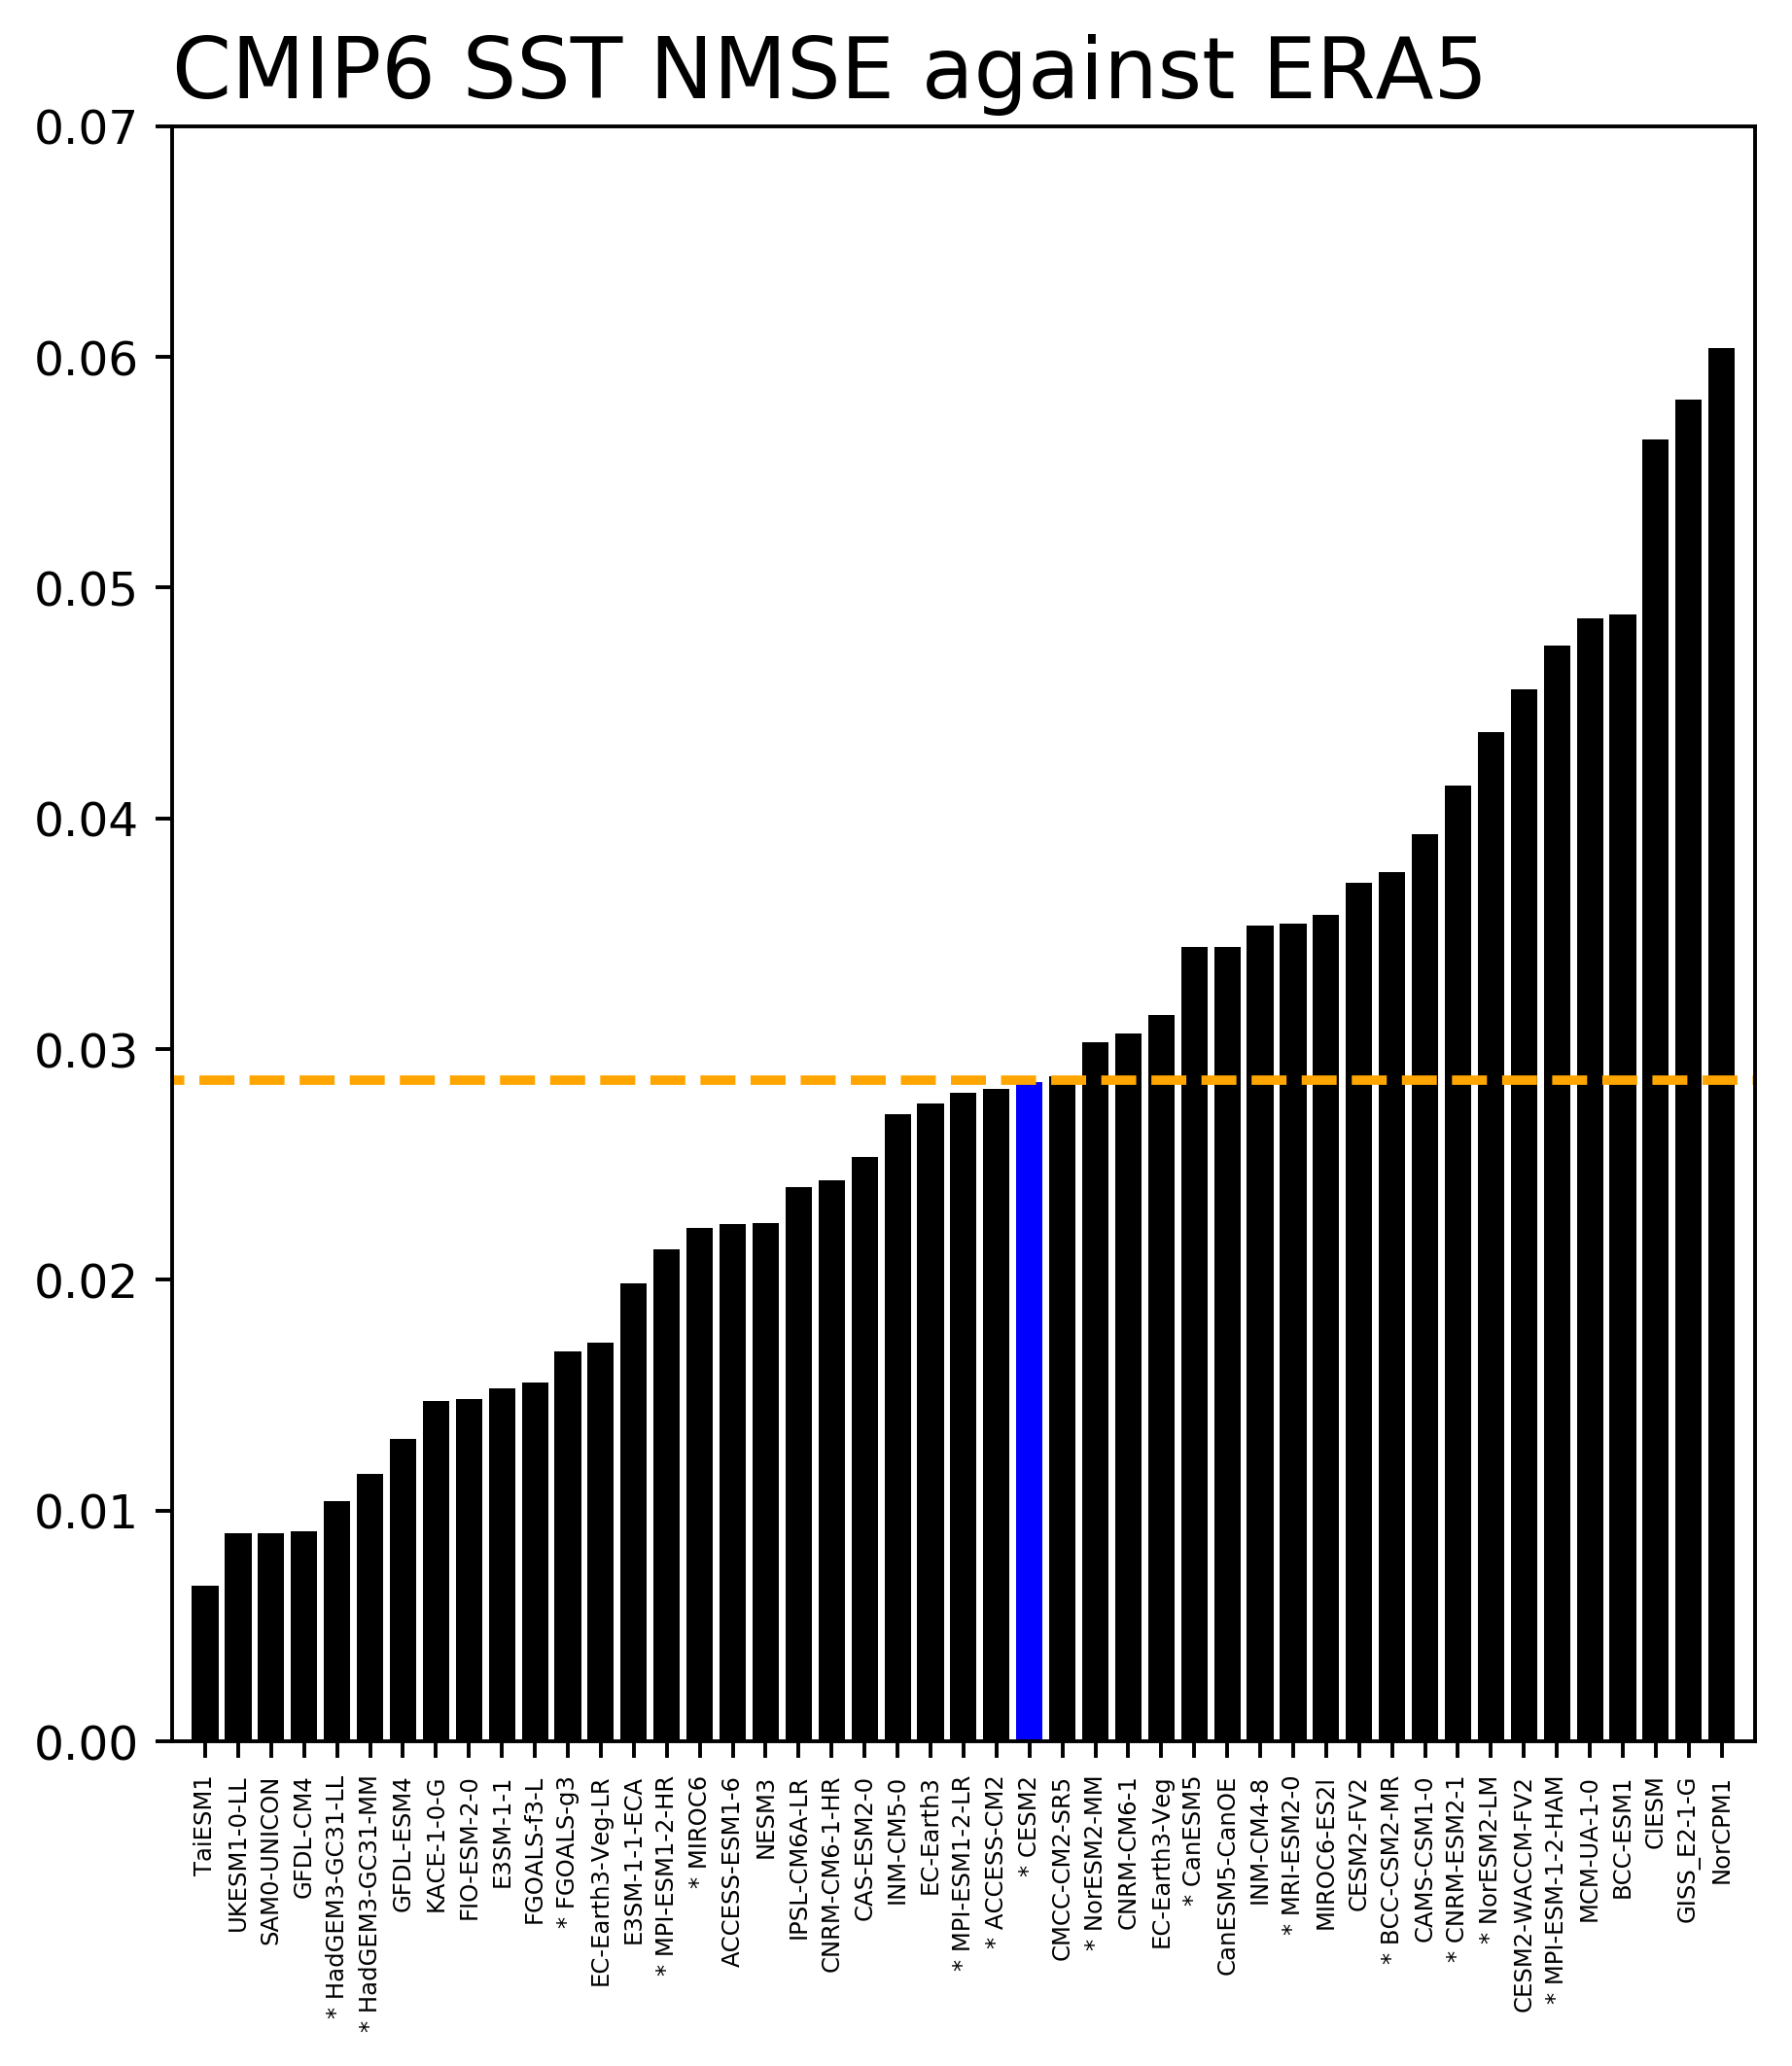

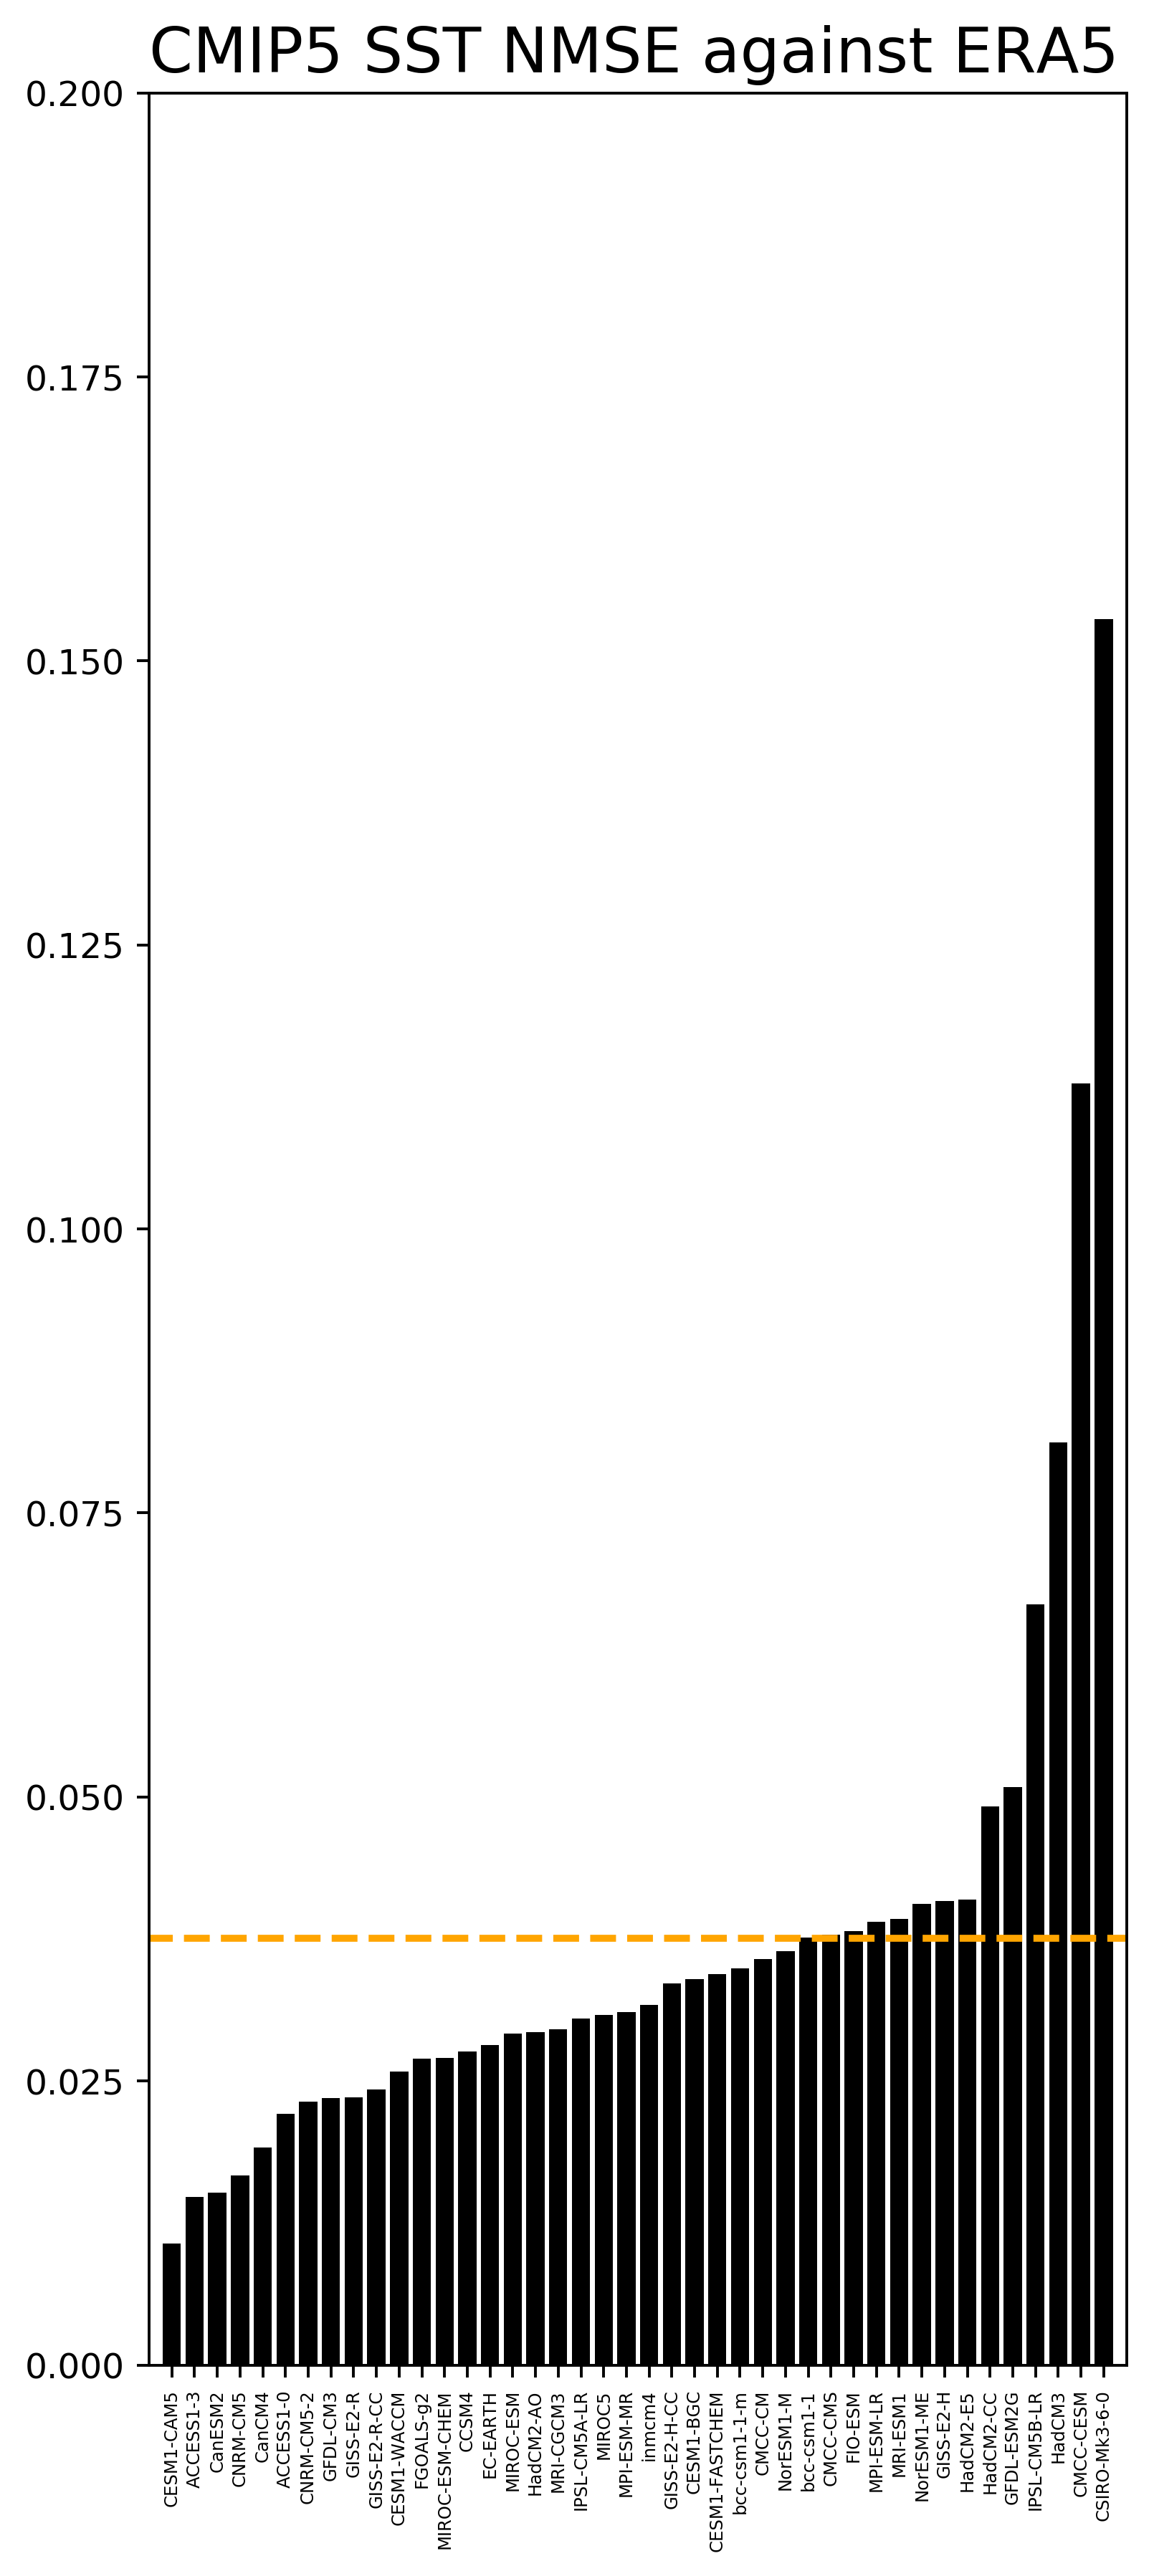

In [9]:
%%time

import csv

print (nmse_cmip5)

nmse_cmip6_sorted = {k: v for k, v in sorted(nmse_cmip6.items(), key=lambda item: item[1])}

sum = 0
count = 0
for iname in nmse_cmip6_sorted.keys():
    sum = sum + nmse_cmip6_sorted[iname]
    count = count + 1

mean_ens = sum / count

fig = P.figure(1,figsize=(6,12),dpi=350)
ax1 = P.subplot(1,1,1)
txt = 'CMIP6 SST NMSE against ERA5'
ax1.set_title(txt,fontsize=18,loc="left")

for iname in nmse_cmip6_sorted.keys():
    if  iname == '* CESM2':
     ax1.bar(iname,nmse_cmip6_sorted[iname],color='b')       
    else:
     ax1.bar(iname,nmse_cmip6_sorted[iname],color='k')

ax1.plot([-10,100],[mean_ens,mean_ens],color='orange',linewidth=2,linestyle="--")    

P.xticks(fontsize=5,rotation=90,ha='center')

#ax1.set_ylabel("[$^o C$]")
ax1.set_aspect(700)
P.axis([-1,len(list(nmse_cmip6_sorted.keys())),0,0.07])

nmse_cmip5_sorted = {k: v for k, v in sorted(nmse_cmip5.items(), key=lambda item: item[1])}

sum = 0
count = 0
for iname in nmse_cmip5_sorted.keys():
    sum = sum + nmse_cmip5_sorted[iname]
    count = count + 1

mean_ens = sum / count

fig = P.figure(2,figsize=(6,12),dpi=350)
ax1 = P.subplot(1,1,1)
txt = 'CMIP5 SST NMSE against ERA5'
ax1.set_title(txt,fontsize=18,loc="left")

for iname in nmse_cmip5_sorted.keys():
     ax1.bar(iname,nmse_cmip5_sorted[iname],color='k')

ax1.plot([-10,100],[mean_ens,mean_ens],color='orange',linewidth=2,linestyle="--")    

P.xticks(fontsize=5,rotation=90,ha='center')

#ax1.set_ylabel("[$^o C$]")
ax1.set_aspect(500)
P.axis([-1,len(list(nmse_cmip5_sorted.keys())),0,0.2])


#Write to .csv file
with open('cmip5_sst_nmse.csv', 'w') as f:
    for key in nmse_cmip5_sorted.keys():
        f.write("%s,%s\n"%(key,nmse_cmip5_sorted[key]))

with open('cmip6_sst_nmse.csv', 'w') as f:
    for key in nmse_cmip6_sorted.keys():
        f.write("%s,%s\n"%(key,nmse_cmip6_sorted[key]))
        
gc.collect()

/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Overwrite existing file: bilinear_192x256_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


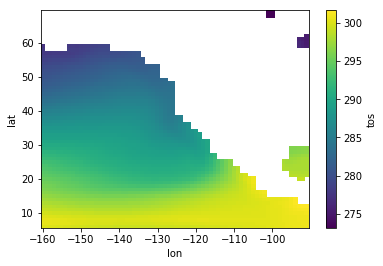

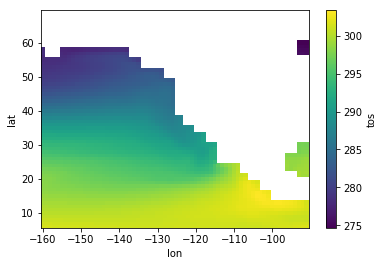

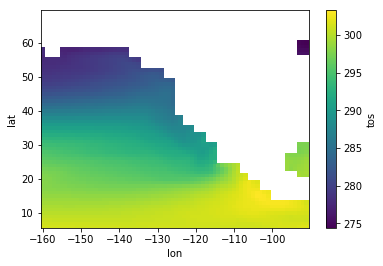

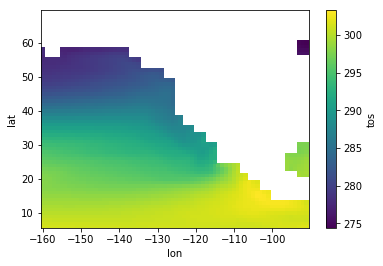

In [316]:
test = sst_cmip5['CSIRO-Mk3-6-0'].mean(dim='time')
P.figure()
test.plot()

test = sst_cmip5['CanESM2'].mean(dim='time')
P.figure()
test.plot()

test = sst_cmip5['CanCM4'].mean(dim='time')
P.figure()
test.plot()

test = _sst_average3(dir,
                    "*CanCM4_historical_r1i1p1*",
                    ds_out,date_start,date_end,sst_era5_final)
test = test.mean(dim='time')
P.figure()
test.plot()

# Components of NMSE

In [18]:
%%time

def compute_nmse_components(gcm,ref):
    # These three components should add up to the total NMSE
    # They will not add up perfectly if there are nan values in either dataset
    
    
    ref_std = np.sqrt( weighted_mean((ref - weighted_mean(ref))**2))
    gcm_std = np.sqrt( weighted_mean((gcm - weighted_mean(gcm))**2))

    print (ref_std.values, gcm_std.values)
    print (weighted_mean(gcm).values,weighted_mean(ref).values)
    df = pd.DataFrame({'gcm':gcm.values.flatten(),'ref':ref.values.flatten()})
    r = df.corr(method='pearson').ref.gcm

    U = (((weighted_mean(gcm) - weighted_mean(ref))/ref_std)**2).values
    
    C = ((r - (gcm_std/ref_std))**2).values
    
    P = (1 - r**2)
    print ("boom")
    return (U,C,P)

u_nmse_cmip6 = {}
c_nmse_cmip6 = {}
p_nmse_cmip6 = {}

'''for key in sst_cmip6.keys():
    print (key)
    #print (compute_nmse_components(sst_cmip6[key].mean(dim='time'),era5_mean))
    u_nmse_cmip6[key], c_nmse_cmip6[key], p_nmse_cmip6[key] = compute_nmse_components(sst_cmip6[key].mean(dim='time'),era5_mean)
    break'''

u,c,p = compute_nmse_components(fix_sst_cmip6['* CESM2'].mean(dim='time'),era5_mean)

print (u)
print (c)
print (p)
print (nmse_cmip6["* CESM2"])

gc.collect()

/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


6.634739501723795 6.521081830131495


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


295.4070588266599 294.4147514104405


/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


boom
0.02236890486482333
0.00016709941364725323
0.008390320523501194
0.028566669392906648
CPU times: user 1min 27s, sys: 22 s, total: 1min 49s
Wall time: 1min 31s


0

# Get the NMSE for CMIP5/6 ensemble members

In [ ]:
%%time

#CESM2 for CMIP6, GFDL-CM2p1 for CMIP5
date_start, date_end = [1970,1,1], [2005,12,31]
dir = "/data/public/gcm/CMIP5/native/month/historical/tos/"

cmip5_ens = {}
cmip5_ens_nmse = {}

ens = ["r1i1p1","r1i1p2","r2i1p1","r2i1p2", \
      "r3i1p1","r3i1p2","r4i1p1","r4i1p2", \
      "r5i1p1","r5i1p2"]

for iens in ens:
 cmip5_ens[iens]  = _sst_average3(dir,
                    "*GISS-E2-R_historical_%s_*" %(iens),
                    ds_out,date_start,date_end,sst_era5_final)

 aaa = cmip5_ens[iens].mean(dim='time')
 cmip5_ens_nmse[iens] = compute_nmse(aaa,era5_mean)
 print (cmip5_ens_nmse[iens])
 
#CMIP6
date_start, date_end = [1980,1,1], [2014,12,31]
dir = "/data/public/gcm/CMIP6/native/mon/historical/tos/"

cmip6_ens = {}
cmip6_ens_nmse = {}

ens = ["r1i1p1f1","r2i1p1f1","r3i1p1f1","r4i1p1f1", \
      "r5i1p1f1","r6i1p1f1","r7i1p1f1","r8i1p1f1", \
      "r9i1p1f1","r10i1p1f1"]

for iens in ens:
 cmip6_ens[iens]  = _sst_average2(dir,
                    "*CESM2_historical_%s_gn*" %(iens),
                    ds_out,date_start,date_end,sst_era5_final)
 
 aaa = cmip6_ens[iens].mean(dim='time') + T0
 cmip6_ens_nmse[iens] = compute_nmse(aaa,era5_mean)
 print (cmip6_ens_nmse[iens])

#Write to .csv file
with open('cmip5_giss-e2-r_ens_nmse_tos.csv', 'w') as f:
    for key in cmip5_ens_nmse.keys():
        f.write("%s,%s\n"%(key,cmip5_ens_nmse[key]))

with open('cmip6_cesm2_ens_nmse_tos.csv', 'w') as f:
    for key in cmip6_ens_nmse.keys():
        f.write("%s,%s\n"%(key,cmip6_ens_nmse[key]))

gc.collect()

Overwrite existing file: bilinear_90x144_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.023568054468618673
Overwrite existing file: bilinear_90x144_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.022214455020163736
Overwrite existing file: bilinear_90x144_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.025348701305491973
Overwrite existing file: bilinear_90x144_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.02302615413756356
Overwrite existing file: bilinear_90x144_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.023987795805134278
Overwrite existing file: bilinear_90x144_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.023890333969329706
Overwrite existing file: bilinear_90x144_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.023416803227935476
Overwrite existing file: bilinear_90x144_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.023419782903740194
Overwrite existing file: bilinear_90x144_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.02357356206057431
Overwrite existing file: bilinear_90x144_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


0.019923392935452436
Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.028566669392906682


/work/srahimi/clone/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.02725019837264905


/work/srahimi/clone/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.026684704549378702


/work/srahimi/clone/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.02901093351979279


/work/srahimi/clone/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.026696925578618583


/work/srahimi/clone/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.03401460669851578


/work/srahimi/clone/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.03265322121125528


/work/srahimi/clone/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.024900985498333892


/work/srahimi/clone/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.029093312803083294


/work/srahimi/clone/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Overwrite existing file: bilinear_384x320_64x70_peri.nc 
 You can set reuse_weights=True to save computing time.


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


# Compute the MAE and populate a dictionary

In [173]:
%%time

names = list(bias.keys())

mae = {}

for iname in names:
    mae[iname] = xr.ufuncs.fabs(bias[iname].mean(dim='lon')).weighted(weights).mean(dim="lat").values

gc.collect()

/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srah

CPU times: user 3min 52s, sys: 1min 35s, total: 5min 28s
Wall time: 4min 24s


5100

# Rank and plot MAE

CPU times: user 452 ms, sys: 54.1 ms, total: 507 ms
Wall time: 504 ms


14720

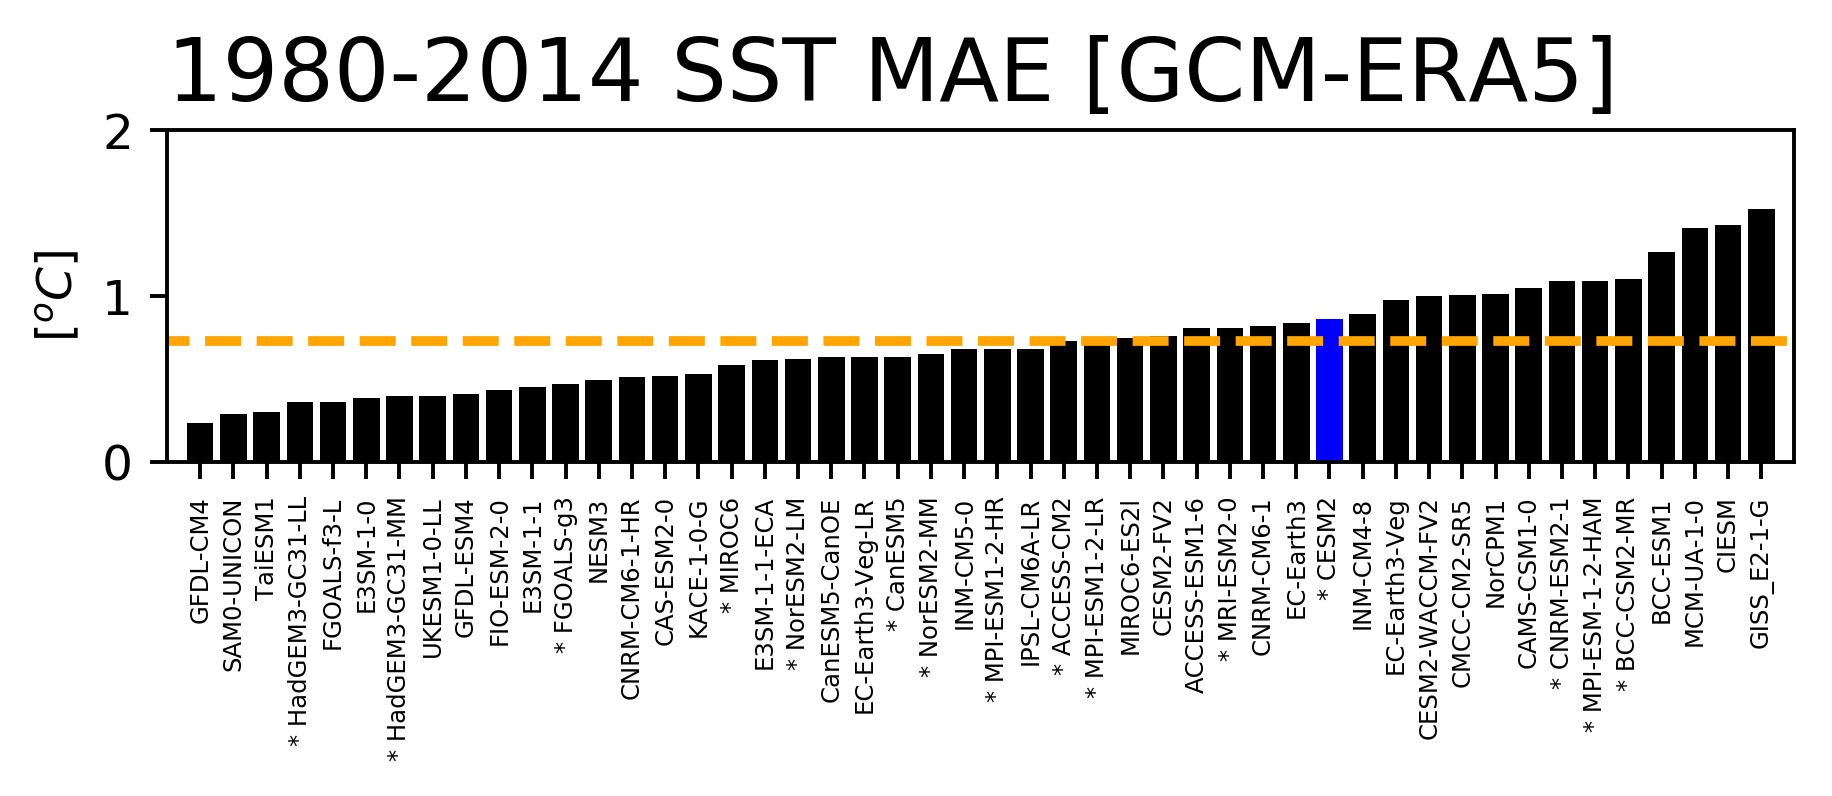

In [178]:
%%time

import csv

mae_sorted = {k: v for k, v in sorted(mae.items(), key=lambda item: item[1])}

sum = 0
count = 0
for iname in mae_sorted.keys():
    sum = sum + mae_sorted[iname]
    count = count + 1

mean_ens = sum / count

fig = P.figure(figsize=(6,12),dpi=350)
ax1 = P.subplot(1,1,1)
txt = '1980-2014 SST MAE [GCM-ERA5]'
ax1.set_title(txt,fontsize=18,loc="left")

for iname in mae_sorted.keys():
    if  iname == '* CESM2':
     ax1.bar(iname,mae_sorted[iname],color='b')       
    else:
     ax1.bar(iname,mae_sorted[iname],color='k')

ax1.plot([-10,100],[mean_ens,mean_ens],color='orange',linewidth=2,linestyle="--")    

P.xticks(fontsize=5,rotation=90,ha='center')

ax1.set_ylabel("[$^o C$]")
ax1.set_aspect(5)
P.axis([-1,len(list(mae_sorted.keys())),0,2])

#Write to .csv file
with open('sst_sorted.csv', 'w') as f:
    for key in mae_sorted.keys():
        f.write("%s,%s\n"%(key,mae_sorted[key]))

gc.collect()

# Test plot

/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/srah

CPU times: user 3min 51s, sys: 1min 36s, total: 5min 28s
Wall time: 4min 22s


102667

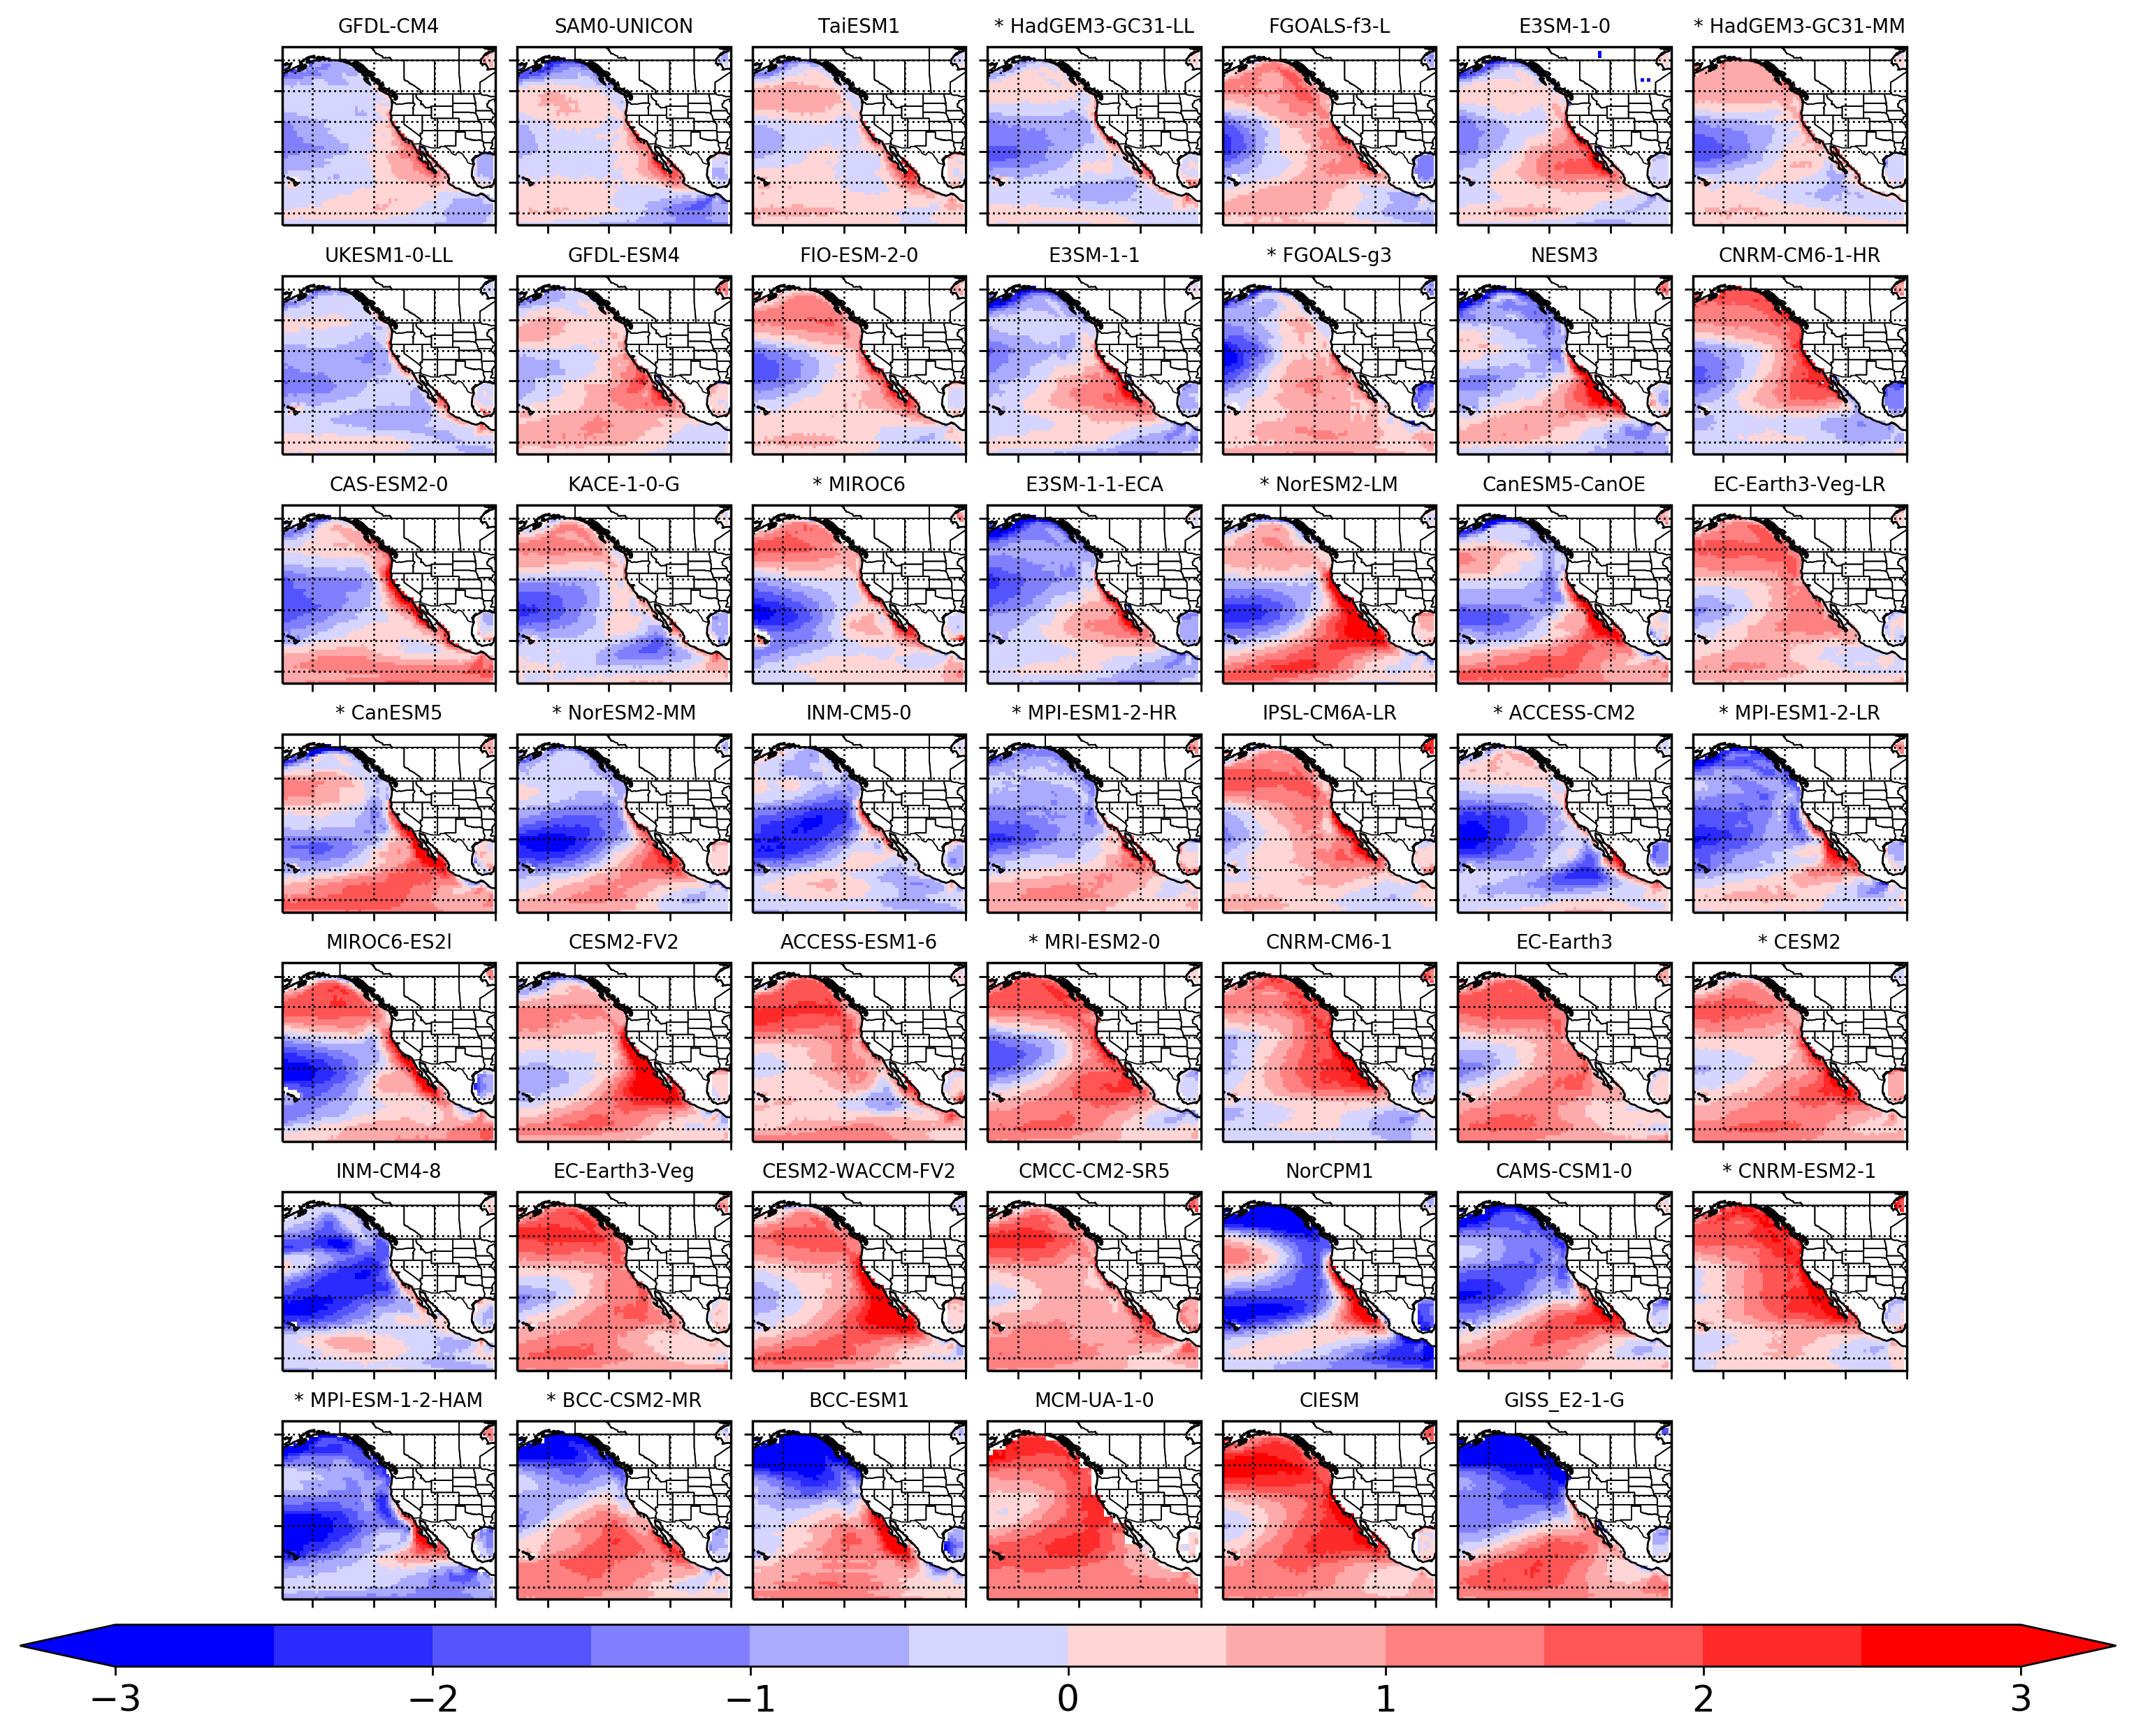

In [176]:
%%time 

levs = np.arange(-3,3.1,0.5)
mycmap = ["blue","white","red"]
norm = matplotlib.colors.BoundaryNorm(levs,len(levs)+1)

colors_to_rgb = []
for ii in mycmap:
 aa = colors.to_rgba(ii)
 colors_to_rgb.append(aa)
cmap = LinearSegmentedColormap.from_list("t2",colors_to_rgb,len(levs))

final_biases = {}
for iname in mae_sorted.keys():
    final_biases[iname] = bias[iname]

cart_proj = crs.PlateCarree()

fig = P.figure(figsize=(12,12),dpi=250)

ax = []
for iax in range(1,len(final_biases)+1):
 ax.append(P.subplot(7,7,iax,projection=cart_proj))

lons = np.arange(-170,-60,20)
lats = np.arange(10,70,10)

count = 0
names = list(final_biases.keys())


for iax in ax:
    
    key = '%s' %(names[count])
    
    iax.set_title("%s" %(key),fontsize=8)
    cs = iax.pcolormesh(bias[key].lon,bias[key].lat,bias[key], \
                cmap=cmap, \
                norm=norm)

    iax.coastlines('50m', linewidth=0.8)
    iax.add_feature(states, linewidth=.5, edgecolor="black")
    gl = iax.gridlines(crs=cart_proj,color="black", linestyle="dotted")
    gl.xlocator = mticker.FixedLocator(lons)
    gl.ylocator = mticker.FixedLocator(lats)
    iax.set_xticks(lons,crs=crs.PlateCarree())
    iax.set_yticks(lats,crs=crs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    iax.xaxis.set_major_formatter(lon_formatter)
    iax.yaxis.set_major_formatter(lat_formatter)
    
    for tick in iax.xaxis.get_major_ticks():
                tick.label.set_visible(False)

    for tick in iax.yaxis.get_major_ticks():
                tick.label.set_visible(False)

    iax.set_extent([-160,-90,6,60])

    count = count + 1

P.subplots_adjust(wspace=0.1,hspace=0.1)

                  
cbar_ax = fig.add_axes([0,0.1, 1, 0.02]) # bottom left corner x,y, and width, height
cb = P.colorbar(cs,cax=cbar_ax,extend="both",orientation="horizontal")
cb.ax.tick_params(labelsize=15)

gc.collect()

# KACE test

Create weight file: bilinear_332x362_64x70_peri.nc


/work/srahimi/clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/work/srahimi/clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


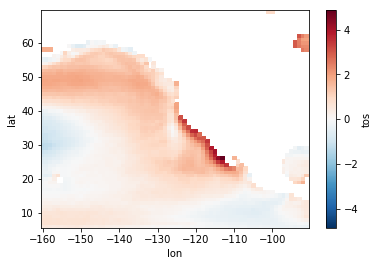

In [165]:
header = "*IPSL-CM6A-LR_historical_r1i1p1f1_gn*"

data = xr.open_mfdataset(dir+header,combine='by_coords')
data = screen_times(data,date_start,date_end)

ds = xr.DataArray(data.tos, dims=['time','y','x'], \
        coords={'lon': (['y', 'x'], data.nav_lon), \
        'lat': (['y', 'x'], data.nav_lat), \
        'time': (['time'], data.time) } )
    
regridder = xe.Regridder(ds, ds_out, 'bilinear',periodic=True,ignore_degenerate=True,reuse_weights=False)
sst = regridder(data.tos) + 273.16
    
diff_sst = sst.mean(dim='time') - sst_era5_final

diff_sst.plot()